# Question 3: Cosine Similarity

In [1]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext.data as data
from models.attention import MultiHeadAttention
from models.embedder import Embedder, FeedForward, Norm, PositionalEncoder, get_clones
from transformers import GPT2Tokenizer

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


## Cosine Similarity Attention

* We're using cosine similarity as our new distance metric:

$\text{Cosim} = \frac{Q \cdot K^T}{\|Q\|\cdot\|K\|}$

* Cosine similarity focuses only on the orientation of the vectors, not their magnitude.
* The only major change here is that we're normalizing the vectors to unit length before taking their dot products.

In [3]:
def cosine_similarity_attention(q, k, v, d_k, mask=None, dropout=None):
    # Calculate norms
    q_norm = torch.norm(q, p=2, dim=-1, keepdim=True)  # Norm of queries
    k_norm = torch.norm(k, p=2, dim=-1, keepdim=True)  # Norm of keys

    dot_product = torch.matmul(q, k.transpose(-2, -1))

    # denominator (||q|| * ||k||)
    denominator = torch.matmul(q_norm, k_norm.transpose(-2, -1))

    # cosine similarity scores
    scores = dot_product / denominator

    if mask is not None:
        mask = mask.unsqueeze(1)
        scores = scores.masked_fill(mask == 0, -1e9)

    scores = F.softmax(scores, dim=-1)

    if dropout is not None:
        scores = dropout(scores)

    output = torch.matmul(scores, v)
    return output

In [4]:
class CosineMultiHeadAttention(MultiHeadAttention):
    def forward(self, q, k, v, mask=None):
        bs = q.size(0)
        k = self.k_linear(k).view(bs, -1, self.h, self.d_k)
        q = self.q_linear(q).view(bs, -1, self.h, self.d_k)
        v = self.v_linear(v).view(bs, -1, self.h, self.d_k)

        k = k.transpose(1, 2)
        q = q.transpose(1, 2)
        v = v.transpose(1, 2)

        scores = cosine_similarity_attention(q, k, v, self.d_k, mask, self.dropout)
        concat = scores.transpose(1, 2).contiguous().view(bs, -1, self.d_model)
        output = self.out(concat)

        return output

## Decoder

We're using `CosineMultiHeadAttention` here.

In [5]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, heads, dropout=0.1):
        super().__init__()
        self.norm_1 = Norm(d_model)
        self.dropout_1 = nn.Dropout(dropout)
        self.attn_1 = CosineMultiHeadAttention(heads, d_model, dropout=dropout)
        self.ff = FeedForward(d_model, dropout=dropout)
        self.norm_2 = Norm(d_model)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, x, trg_mask):
        x2 = self.norm_1(x)
        x = x + self.dropout_1(self.attn_1(x2, x2, x2, trg_mask))
        x2 = self.norm_2(x)
        x = x + self.dropout_2(self.ff(x2))
        return x

In [6]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout):
        super().__init__()
        self.embed = Embedder(vocab_size, d_model)
        self.pe = PositionalEncoder(d_model, dropout=dropout)
        self.layers = get_clones(DecoderLayer(d_model, heads, dropout), N)
        self.norm = Norm(d_model)

    def forward(self, trg, trg_mask):
        x = self.embed(trg)
        x = self.pe(x)
        for layer in self.layers:
            x = layer(x, trg_mask)
        return self.norm(x)

## Transformer

In [7]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, d_model, N, heads, dropout, device):
        super().__init__()
        self.device = device
        self.vocab_size = vocab_size
        self.decoder = Decoder(vocab_size, d_model, N, heads, dropout)
        self.out = nn.Linear(d_model, vocab_size)

    def forward(self, trg, trg_mask):
        d_output = self.decoder(trg, trg_mask)
        output = self.out(d_output)
        return output

## No-Peak Mask

In [8]:
def nopeak_mask(size, device):
    np_mask = torch.triu(torch.ones((1, size, size), device=device), 1).bool()
    return np_mask


def create_src_mask(src, pad_token_id, device):
    src_mask = (src != pad_token_id).unsqueeze(-2)
    return src_mask

## Data Feeder

### Tokenizer

In [9]:
TOKENIZER = GPT2Tokenizer.from_pretrained("gpt2")

In [10]:
TOKENIZER.add_special_tokens(
    {"pad_token": "[PAD]", "bos_token": "<sos>", "eos_token": "<eos>"}
)
TOKENIZER.pad_token_id, TOKENIZER.bos_token_id, TOKENIZER.eos_token_id

(50257, 50258, 50259)

In [11]:
def tokenize(text):
    tokens = TOKENIZER.encode(
        text,
        add_special_tokens=True,
        max_length=512,  # sequence length
        truncation=True,
    )
    return tokens

In [12]:
def load_dataset(path):
    examples = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                src_line = line.strip()
                examples.append(data.Example.fromlist([src_line], [("src", SRC)]))
    dataset = data.Dataset(examples, [("src", SRC)])
    return dataset

### BucketIterator

In [13]:
SRC = data.Field(
    use_vocab=False,
    tokenize=tokenize,
    pad_token=TOKENIZER.pad_token_id,
    unk_token=TOKENIZER.unk_token_id,
    init_token=TOKENIZER.bos_token_id,
    eos_token=TOKENIZER.eos_token_id,
    lower=False,
    batch_first=True,
    fix_length=512,
)

In [14]:
train_data = load_dataset("data/wiki2.train.txt")

In [15]:
valid_data = load_dataset("data/wiki2.valid.txt")

## Training

In [16]:
def get_model(vocab_size, d_model=512, N=6, heads=8, dropout=0.1, device="cpu"):
    """Initialize and return the Transformer model

    Args:
        vocab_size (int): The size of the vocabulary.
        d_model (int): The dimensionality of the model.
        N (int): The number of decoder layers.
        heads (int): The number of attention heads.
        dropout (float): The dropout rate.

    Returns:
        Transformer: The initialized Transformer model.
    """
    model = Transformer(vocab_size, d_model, N, heads, dropout, device)
    model.to(device)
    return model

In [17]:
def train_model(
    model, train_iterator, valid_iterator, optimizer, device, epochs, print_every=50
):
    train_losses = []
    train_perplexities = []
    valid_losses = []
    valid_perplexities = []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        intermediate_train_loss = 0
        start = time.time()

        for i, batch in enumerate(train_iterator):
            src = batch.src.to(device)
            src_mask = create_src_mask(src, TOKENIZER.pad_token_id, device)
            no_peak_mask = nopeak_mask(src.size(1), device)

            # https://github.com/SamLynnEvans/Transformer/blob/master/Batch.py#L20
            preds = model(src, src_mask & no_peak_mask)
            preds = preds[:, :-1, :]  # exclude the last time step predictions
            ys = src[:, 1:].contiguous().view(-1)  # Targets shifted by one position

            optimizer.zero_grad()
            loss = F.cross_entropy(
                preds.reshape(-1, preds.size(-1)),
                ys,
                ignore_index=TOKENIZER.pad_token_id,
            )
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            intermediate_train_loss += loss.item()

            if (i + 1) % print_every == 0:
                p = int(100 * (i + 1) / len(train_iterator))
                avg_loss = intermediate_train_loss / print_every
                print(
                    f"{(time.time() - start) // 60}m: epoch {epoch + 1} [{p}%] Train loss = {avg_loss:.3f}",
                    end="\r",
                )
                intermediate_train_loss = 0

        avg_train_loss = total_train_loss / len(train_iterator)
        train_perplexity = torch.exp(torch.tensor(avg_train_loss)).item()
        train_losses.append(avg_train_loss)
        train_perplexities.append(train_perplexity)

        # Validation phase
        model.eval()
        total_valid_loss = 0
        with torch.no_grad():
            for i, batch in enumerate(valid_iterator):
                src = batch.src.to(device)
                src_mask = create_src_mask(src, TOKENIZER.pad_token_id, device)
                no_peak_mask = nopeak_mask(src.size(1), device)

                preds = model(src, src_mask & no_peak_mask)
                preds = preds[:, :-1, :]
                ys = src[:, 1:].contiguous().view(-1)

                loss = F.cross_entropy(
                    preds.reshape(-1, preds.size(-1)),
                    ys,
                    ignore_index=TOKENIZER.pad_token_id,
                )
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_iterator)
        valid_perplexity = torch.exp(torch.tensor(avg_valid_loss)).item()
        valid_losses.append(avg_valid_loss)
        valid_perplexities.append(valid_perplexity)

        print(
            f"Epoch {epoch + 1}: Train loss = {avg_train_loss:.3f}, Train Perplexity = {train_perplexity:.3f}"
        )
        print(
            f"Epoch {epoch + 1}: Validation loss = {avg_valid_loss:.3f}, Validation Perplexity = {valid_perplexity:.3f}"
        )

    return train_losses, train_perplexities, valid_losses, valid_perplexities

### Training the Model

In [18]:
train_iterator = data.BucketIterator(
    train_data,
    batch_size=20,
    device=DEVICE,
    sort=False,
    repeat=False,
)

In [19]:
valid_iterator = data.BucketIterator(
    valid_data,
    batch_size=20,
    device=DEVICE,
    sort=False,
    repeat=False,
)

We're using the same hyperparameters as earlier as they work well.

In [20]:
vocab_size = len(TOKENIZER)
model = get_model(vocab_size, d_model=512, N=6, heads=8, dropout=0.1, device=DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
results = train_model(
    model, train_iterator, valid_iterator, optimizer, DEVICE, epochs=5, print_every=50
)

Epoch 1: Train loss = 4.467, Train Perplexity = 87.128
Epoch 1: Validation loss = 2.645, Validation Perplexity = 14.090
Epoch 2: Train loss = 2.238, Train Perplexity = 9.373
Epoch 2: Validation loss = 1.533, Validation Perplexity = 4.630
Epoch 3: Train loss = 1.349, Train Perplexity = 3.855
Epoch 3: Validation loss = 1.083, Validation Perplexity = 2.954
Epoch 4: Train loss = 0.925, Train Perplexity = 2.523
Epoch 4: Validation loss = 0.917, Validation Perplexity = 2.502
Epoch 5: Train loss = 0.690, Train Perplexity = 1.994
Epoch 5: Validation loss = 0.767, Validation Perplexity = 2.154


```python
Epoch 1: Train loss = 4.467, Train Perplexity = 87.128
Epoch 1: Validation loss = 2.645, Validation Perplexity = 14.090
Epoch 2: Train loss = 2.238, Train Perplexity = 9.373
Epoch 2: Validation loss = 1.533, Validation Perplexity = 4.630
Epoch 3: Train loss = 1.349, Train Perplexity = 3.855
Epoch 3: Validation loss = 1.083, Validation Perplexity = 2.954
Epoch 4: Train loss = 0.925, Train Perplexity = 2.523
Epoch 4: Validation loss = 0.917, Validation Perplexity = 2.502
Epoch 5: Train loss = 0.690, Train Perplexity = 1.994
Epoch 5: Validation loss = 0.767, Validation Perplexity = 2.154
```

* It's interesting to note that adding the normalization in the cosine distance, marginally slows down the training.
* Due to the norm, we had to reduce our batch size to accomodate additional attention weights in our memory. This further slowed down our training.
* Furthermore, our perplexities here are poorer than they were for the model using the standard attention.

In [22]:
train_losses, train_perplexities, valid_losses, valid_perplexities = results

### Training Results

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [24]:
epochs = list(range(1, len(train_losses) + 1))
train_data = pd.DataFrame(
    {
        "Epoch": epochs,
        "Train Loss": train_losses,
        "Train Perplexity": train_perplexities,
    }
)

valid_data = pd.DataFrame(
    {
        "Epoch": epochs,
        "Validation Loss": valid_losses,
        "Validation Perplexity": valid_perplexities,
    }
)

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


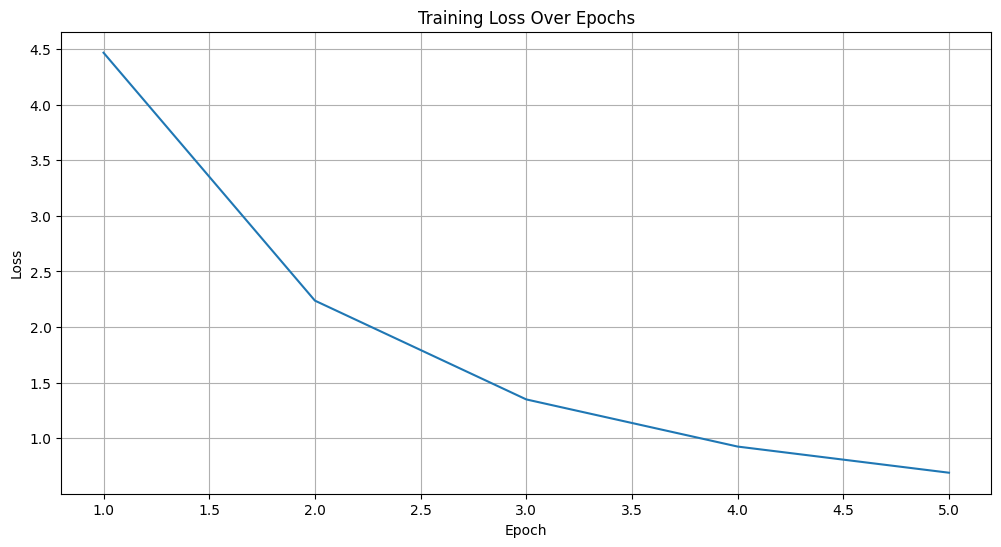

In [25]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_data, x="Epoch", y="Train Loss")
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


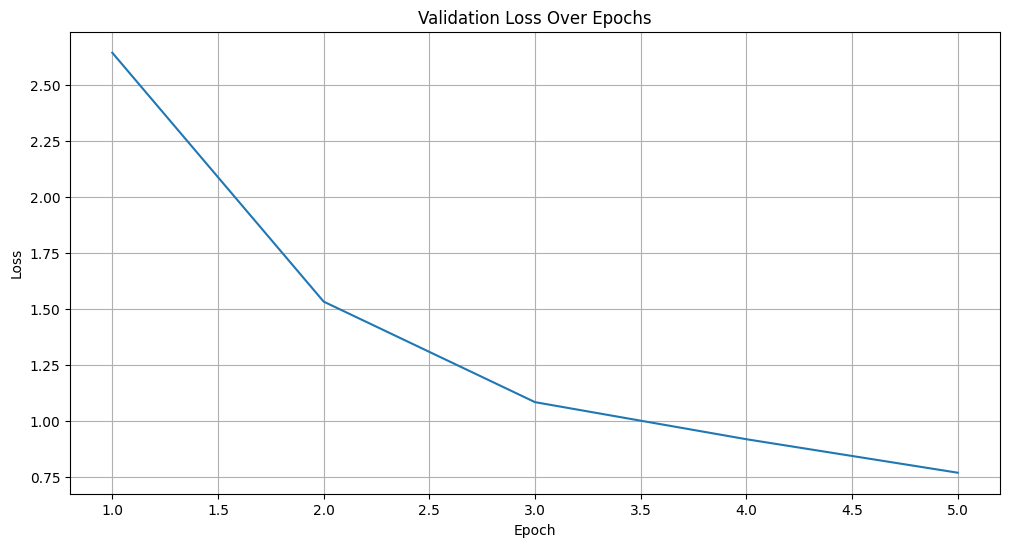

In [26]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=valid_data, x="Epoch", y="Validation Loss")
plt.title("Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


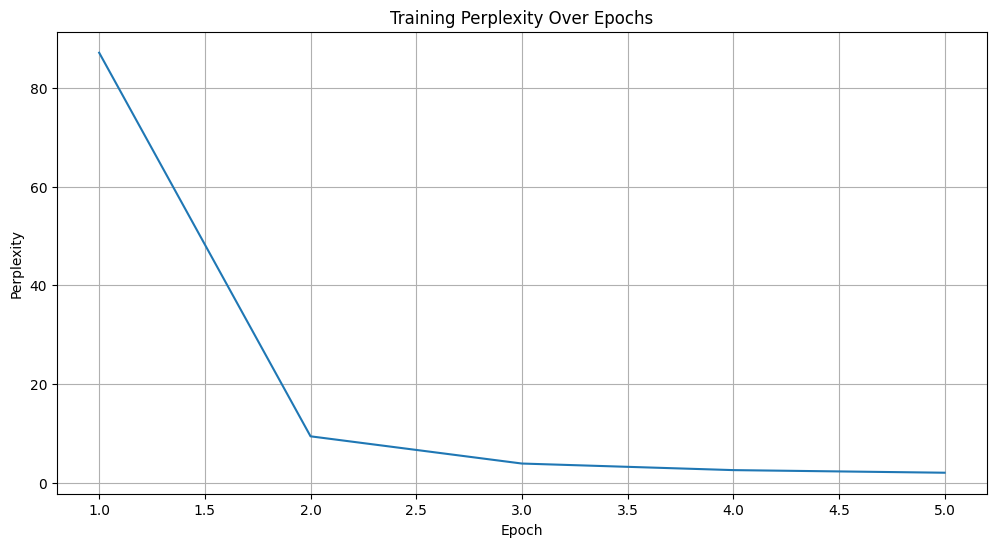

In [27]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=train_data, x="Epoch", y="Train Perplexity")
plt.title("Training Perplexity Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()

/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/ubuntu/venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


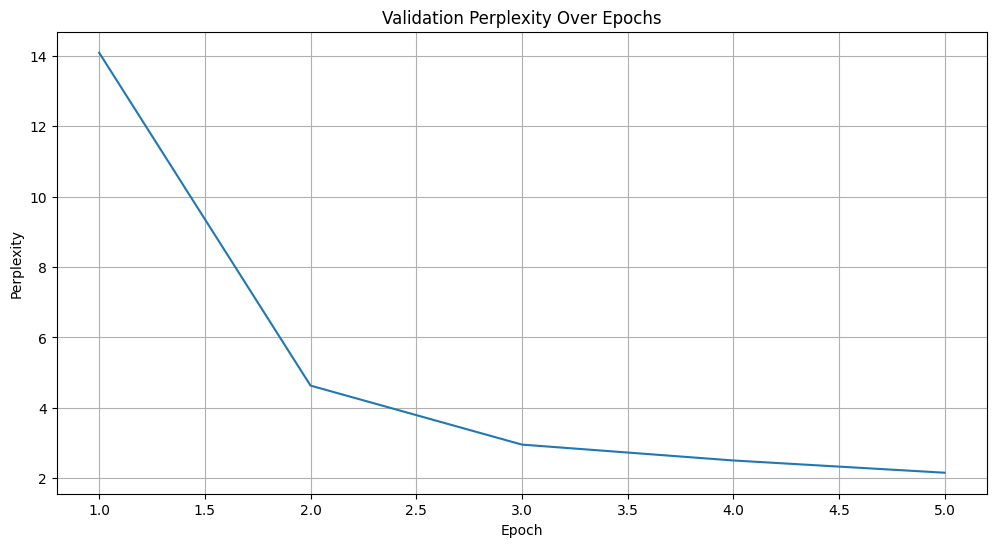

In [28]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=valid_data, x="Epoch", y="Validation Perplexity")
plt.title("Validation Perplexity Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.grid(True)
plt.show()

## Testing

In [29]:
torch.save(model.state_dict(), "model_wgts/model_weights_q3.pth")

In [30]:
saved_model = get_model(
    vocab_size, d_model=512, N=6, heads=8, dropout=0.1, device=DEVICE
)

In [31]:
saved_model.load_state_dict(
    torch.load("model_wgts/model_weights_q3.pth", map_location=DEVICE)
)

<All keys matched successfully>

In [32]:
test_data = load_dataset("data/wiki2.test.txt")

In [33]:
test_iterator = data.BucketIterator(
    test_data,
    batch_size=25,
    device=DEVICE,
    sort=False,
    repeat=False,
)

In [34]:
def test_model(model, iterator, device):
    model.eval()
    total_test_loss = 0

    with torch.no_grad():
        for batch in iterator:
            src = batch.src.to(device)
            src_mask = create_src_mask(src, TOKENIZER.pad_token_id, device)
            no_peak_mask = nopeak_mask(src.size(1), device)

            preds = model(src, src_mask & no_peak_mask)
            preds = preds[:, :-1, :]  # exclude the last time step predictions
            ys = (
                src[:, 1:].contiguous().view(-1)
            )  # Targets shifted by one position, assuming next-word prediction

            loss = F.cross_entropy(
                preds.reshape(-1, preds.size(-1)),
                ys,
                ignore_index=TOKENIZER.pad_token_id,
            )
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(iterator)
    test_perplexity = torch.exp(torch.tensor(avg_test_loss)).item()

    return avg_test_loss, test_perplexity

In [35]:
loss, perplexity = test_model(saved_model, test_iterator, DEVICE)

In [36]:
print("Average Loss:", loss)

Average Loss: 0.7615926484095639


In [37]:
print("Perplexity:", perplexity)

Perplexity: 2.1416842937469482


* Our loss and perplexities are slightly worser than the model that uses standard attention.
* Our model also takes marginally longer to train due to the cosine similarity devision.
* One possible reason is that cosine similarity normalizes the magnitude of the vectors, focusing only on the direction.
* This can lead to the loss of important magnitude information which can be useful in certain contexts and datasets.

## Using Saved Weights

In [38]:
def predict_next_token(text, model, tokenizer, device):
    token_ids = tokenizer.encode(text, return_tensors="pt")
    token_ids = token_ids.to(device)

    src_mask = create_src_mask(token_ids, tokenizer.pad_token_id, DEVICE)

    model.eval()

    with torch.no_grad():
        outputs = model(token_ids, src_mask)

    logits = outputs[0, -1, :]
    probs = torch.nn.functional.softmax(logits, dim=-1)
    predicted_token_id = torch.argmax(probs).item()

    predicted_token = tokenizer.decode([predicted_token_id])

    return predicted_token

In [39]:
def predict_next_n_tokens(text, model, tokenizer, device, n):
    for _ in range(n):
        next_token = predict_next_token(text, model, tokenizer, device)
        text += " " + next_token
    return text

In [40]:
text = """When Japan began the Pacific War on 8 December , the sisters sortied for the <unk>
 Islands with four other battleships and the light carrier <unk> as distant cover for the fleet
 attacking Pearl Harbor , and returned six days later . On 11 March 1942 <unk> and <unk> sortied
 from their anchorage at <unk> to join the unsuccessful search for the American carrier force that
 had attacked Marcus Island a week earlier . Similarly they pursued but did not catch the American
 carriers that had launched the <unk> Raid on 18 April . 
 During gunnery training on 5 May ,"""
n = 10

In [41]:
predicted_sequence = predict_next_n_tokens(text, saved_model, TOKENIZER, DEVICE, n)
print("Extended sequence with predicted tokens:", predicted_sequence)

Extended sequence with predicted tokens: When Japan began the Pacific War on 8 December , the sisters sortied for the <unk>
 Islands with four other battleships and the light carrier <unk> as distant cover for the fleet
 attacking Pearl Harbor , and returned six days later . On 11 March 1942 <unk> and <unk> sortied
 from their anchorage at <unk> to join the unsuccessful search for the American carrier force that
 had attacked Marcus Island a week earlier . Similarly they pursued but did not catch the American
 carriers that had launched the <unk> Raid on 18 April . 
 During gunnery training on 5 May ,  or  or  or  or  or  or  or  or  or  or


Ground Truth:

```txt
When Japan began the Pacific War on 8 December , the sisters sortied for the <unk> Islands with four other battleships and the light carrier <unk> as distant cover for the fleet attacking Pearl Harbor , and returned six days later . On 11 March 1942 <unk> and <unk> sortied from their anchorage at <unk> to join the unsuccessful search for the American carrier force that had attacked Marcus Island a week earlier . Similarly they pursued but did not catch the American carriers that had launched the <unk> Raid on 18 April . 
 During gunnery training on 5 May , [there was a premature detonation in the left gun]
```

This is what our model predicts.